In [16]:
import sys
sys.path.append('/ML_Forex_Forecasting')
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# Data Extraction #

In [17]:
eur_chf = pd.read_csv("../eurchf.csv", parse_dates=['Date'])
eur_chf = eur_chf[['Date', 'Close', 'Open', 'High', 'Low']]
print(f"EUR/CHF: {eur_chf.shape}")
display(eur_chf.head())

EUR/CHF: (262, 5)


,Date,Close,Open,High,Low
0,2022-12-01,0.98372,0.98372,0.98855,0.98222
1,2022-12-02,0.98583,0.98583,0.98693,0.98230
2,2022-12-05,0.98731,0.98731,0.99089,0.98500
3,2022-12-06,0.98912,0.98912,0.99083,0.98603
4,2022-12-07,0.98599,0.98599,0.98952,0.98380


In [18]:
gold = pd.read_csv("../gold.csv", parse_dates=['Date'])
gold = gold[['Date', 'Close*']]
gold.rename(columns = {'Close*' : 'Gold'}, inplace = True)

stoxx = pd.read_csv("../stoxx.csv", parse_dates=['Date'])
stoxx = stoxx[['Date', 'Close']]
stoxx.rename(columns = {'Close' : 'Stoxx'}, inplace = True)

smi = pd.read_csv("../smi.csv", parse_dates=['Date'])
smi = smi[['Date', 'Close']]
smi.rename(columns = {'Close' : 'SMI'}, inplace = True)

print(f"Gold: {gold.shape}")
display(gold.head())
print(f"STOXX: {stoxx.shape}")
display(stoxx.head())
print(f"SMI: {smi.shape}")
display(smi.head())

Gold: (253, 2)


,Date,Gold
0,2023-12-01,2058.5
1,2023-11-30,2038.1
2,2023-11-29,2047.1
3,2023-11-28,2039.7
4,2023-11-27,2011.8


STOXX: (254, 2)


,Date,Stoxx
0,2022-12-01,3984.500000
1,2022-12-02,3977.899902
2,2022-12-05,3956.530029
3,2022-12-06,3939.189941
4,2022-12-07,3920.899902


SMI: (254, 2)


,Date,SMI
0,2022-12-01,11238.200195
1,2022-12-02,11198.129883
2,2022-12-05,11194.669922
3,2022-12-06,11109.330078
4,2022-12-07,11009.950195


In [19]:
df = eur_chf.merge(gold[['Date', 'Gold']], on = 'Date', how = 'inner')
df = df.merge(stoxx[['Date', 'Stoxx']], on = 'Date', how = 'inner')
df = df.merge(smi[['Date', 'SMI']], on = 'Date', how = 'inner')

df

,Date,Close,Open,High,Low,Gold,Stoxx,SMI
0,2022-12-01,0.98372,0.98372,0.98855,0.98222,1801.1,3984.500000,11238.200195
1,2022-12-02,0.98583,0.98583,0.98693,0.98230,1795.9,3977.899902,11198.129883
2,2022-12-05,0.98731,0.98731,0.99089,0.98500,1767.4,3956.530029,11194.669922
3,2022-12-06,0.98912,0.98912,0.99083,0.98603,1769.3,3939.189941,11109.330078
4,2022-12-07,0.98599,0.98599,0.98952,0.98380,1785.5,3920.899902,11009.950195
...,...,...,...,...,...,...,...,...
213,2023-11-27,0.96517,0.96517,0.96587,0.96220,2011.8,4354.410156,10821.059570
214,2023-11-28,0.96438,0.96438,0.96554,0.96308,2039.7,4348.020020,10760.379883
215,2023-11-29,0.96510,0.96510,0.96515,0.95969,2047.1,4370.529785,10802.879883
216,2023-11-30,0.95835,0.95835,0.95854,0.94807,2038.1,4382.470215,10854.320313


In [20]:
cols = df.columns[1:]

# Dickey fuller stationarity test #

In [21]:
def dickey_fuller_test(df,var, verbose = False):
    result = adfuller(df[var].values)
    #Extracting the values from the results:
    if verbose:

        print(f"Dickey-Fuller test for feature: {var}")

        print('Test Statistic: %f' % result[0])

        print('p-value: %f' % result[1])

        print('Critical Values:')

        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
        if result[0] < result[4]["5%"]:
            print ("Reject H0 - Time Series is Stationary")
        else:
            print ("Failed to Reject H0 - Time Series is Non-Stationary")

    if result[0] < result[4]["5%"]:
        return True
    
    return False

In [22]:
def test_stationarity(df, cols):
    res = {}
    for col in cols:
        if not dickey_fuller_test(df, col, verbose = False):
            res[col] = False

        else:
            res[col] = True
    return res

In [23]:
test_stationarity(df, cols)

{'Close': False,
 'Open': False,
 'High': False,
 'Low': False,
 'Gold': False,
 'Stoxx': False,
 'SMI': False}

In [24]:
diff_data = diff(df, k_diff = 1)
test_stationarity(diff_data, cols)

{'Close': True,
 'Open': True,
 'High': True,
 'Low': True,
 'Gold': True,
 'Stoxx': True,
 'SMI': True}

# Granger causality #

In [25]:
from statsmodels.tsa.stattools import grangercausalitytests

def grangers_causation_matrix(data, variables, maxlag = 15, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [26]:
grangers_causation_matrix(diff_data, cols)

,Close_x,Open_x,High_x,Low_x,Gold_x,Stoxx_x,SMI_x
Close_y,1.0000,0.0277,0.0000,0.0000,0.0745,0.4583,0.3505
Open_y,0.0200,1.0000,0.0000,0.0000,0.0665,0.4995,0.3721
High_y,0.0213,0.0255,1.0000,0.0015,0.4198,0.0831,0.0048
Low_y,0.0037,0.0038,0.0000,1.0000,0.0144,0.0912,0.0609
Gold_y,0.0261,0.0268,0.0931,0.0061,1.0000,0.0301,0.0735
Stoxx_y,0.3040,0.3081,0.3974,0.2079,0.2803,1.0000,0.0650
SMI_y,0.5334,0.5455,0.0791,0.0304,0.0062,0.4685,1.0000


# Autocorrelograms #

In [29]:
def plot_autocorrelograms(df,var):
    ACF = plot_acf(df[var].dropna(),lags=20)
    plt.title(f"Autocorrelation for {var}")
    PACF = plot_pacf(df[var].dropna(),lags=20)
    plt.title(f"Partial Autocorrelation for {var}")

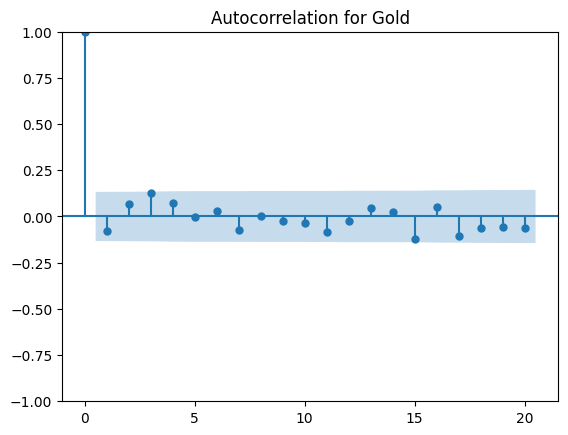

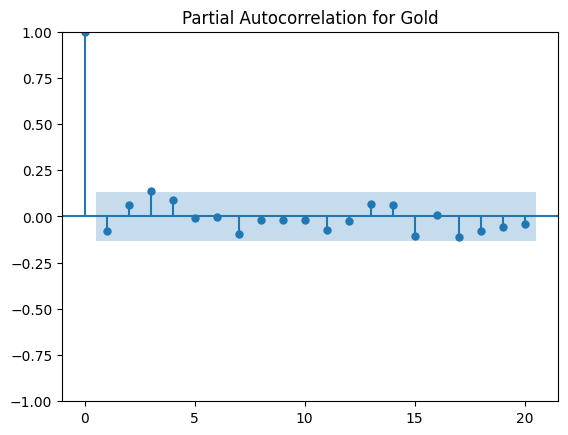

In [30]:
plot_autocorrelograms(diff_data, 'Gold')

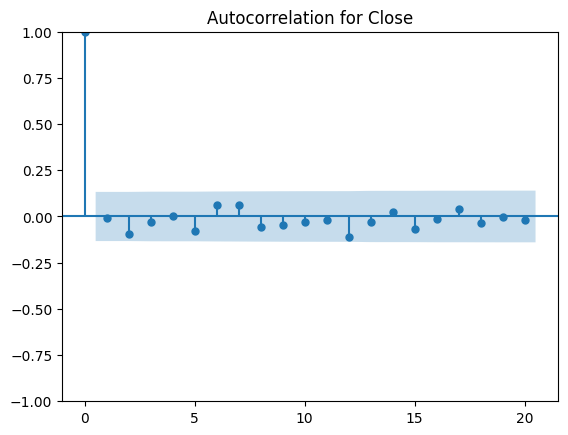

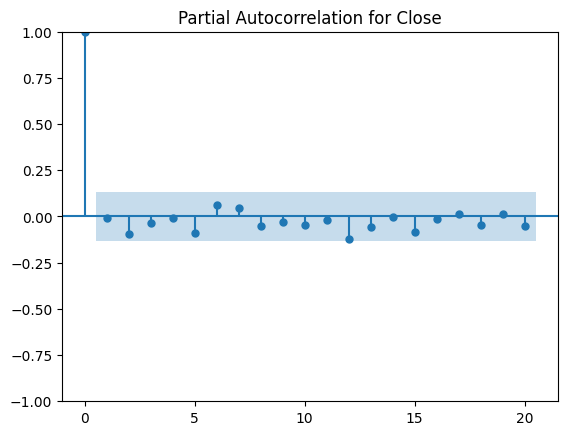

In [31]:
plot_autocorrelograms(diff_data, 'Close')

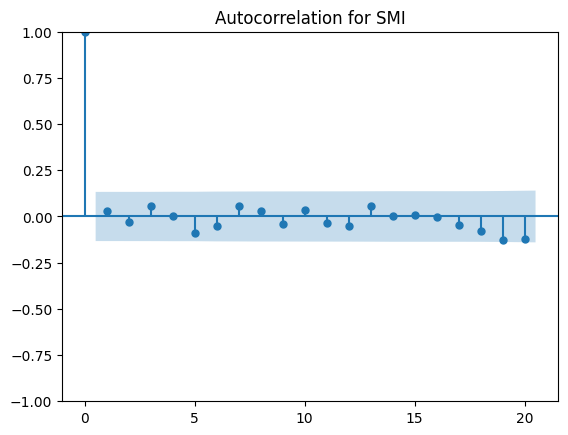

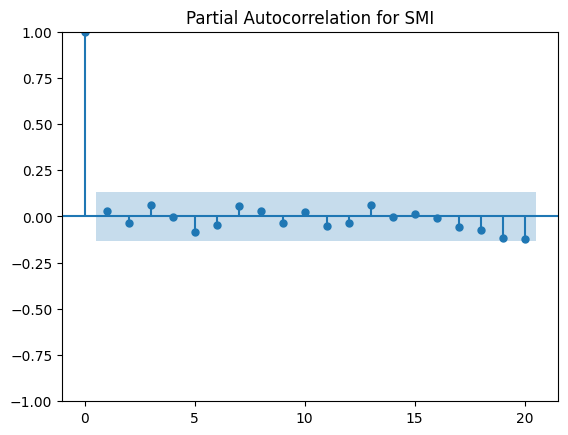

In [32]:
plot_autocorrelograms(diff_data, 'SMI')

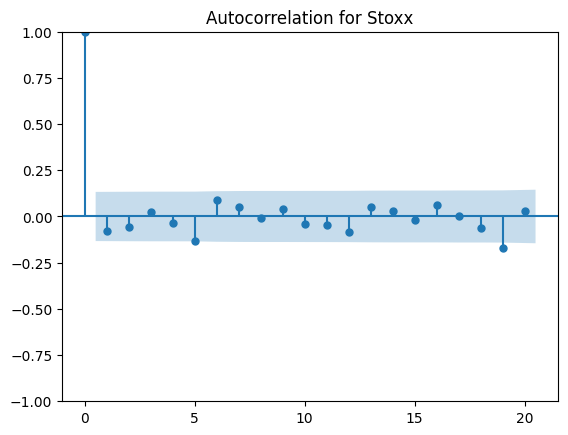

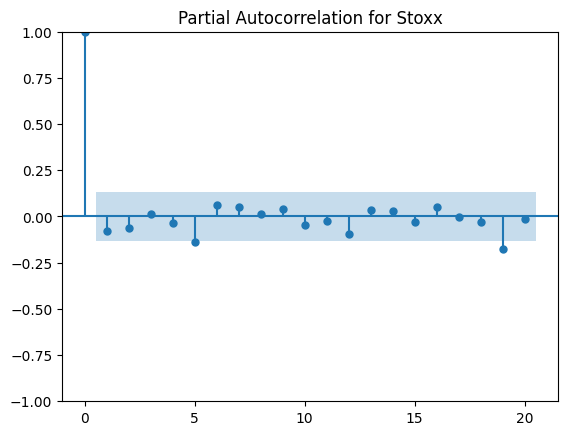

In [33]:
plot_autocorrelograms(diff_data, 'Stoxx')

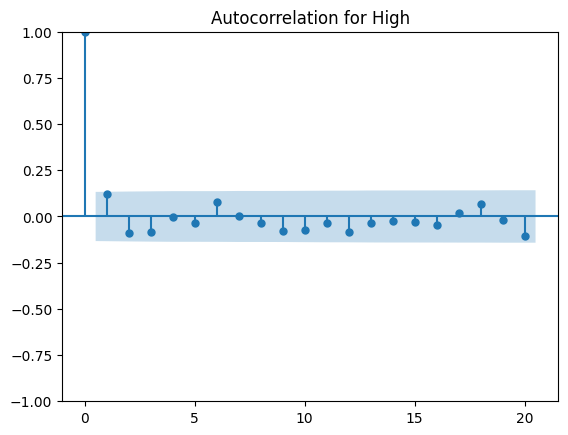

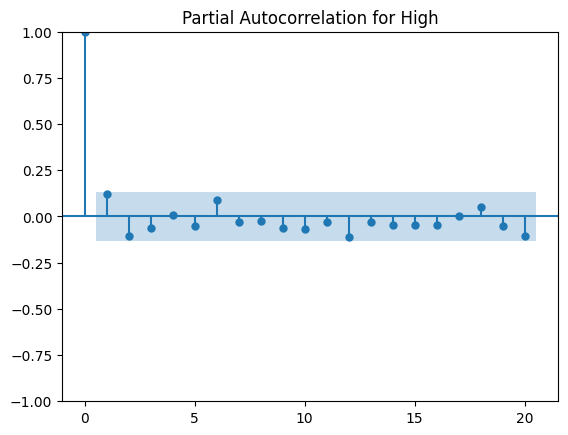

In [34]:
plot_autocorrelograms(diff_data, 'High')

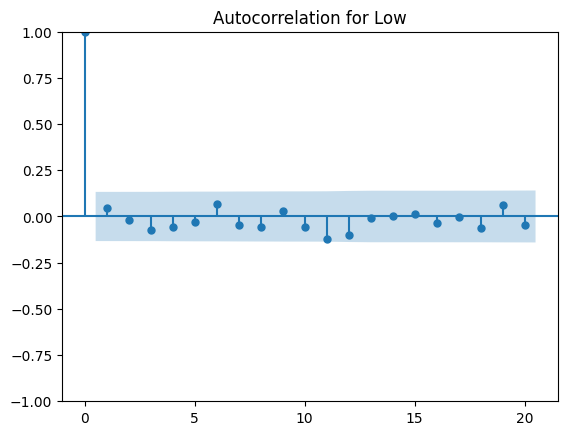

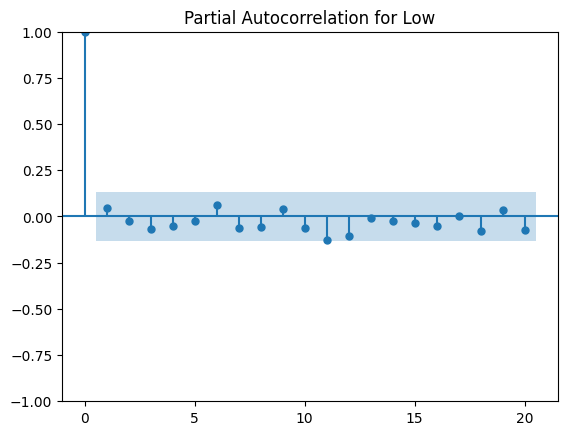

In [35]:
plot_autocorrelograms(diff_data, 'Low')

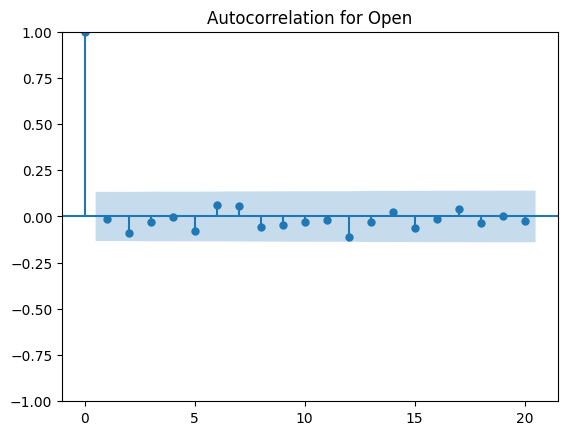

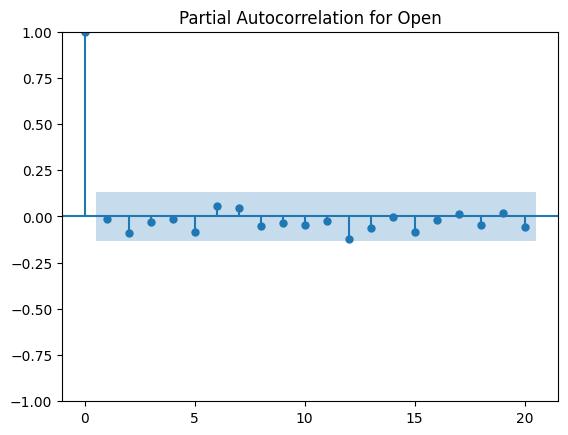

In [36]:
plot_autocorrelograms(diff_data, 'Open')

# Tests #

In [54]:
data = df.copy()
df = data.dropna()

# train_size = int(len(df) * 0.8)
# train, test = df[:train_size], df[train_size:]
train, test = df[:-5], df[-5:]

data = train

diff_data = diff(data, k_diff=1)
diff_test = diff(df[-6:], k_diff=1)

p = np.arange(1,11)
q = np.arange(1,11)
models = []
orders = []
MSEs = []
for i in p:
    for j in q:
        orders.append((i,j))
        model = VARMAX(endog=diff_data[['Close','Gold', 'Stoxx', 'SMI']], order=(i,j), mle_regression = True, filter_concentrated = True, initialization='approximate_diffuse')
        model_fit = model.fit(disp=False)
        pred = pd.DataFrame()
        pred['prediction'] = data.iloc[-1]['Close'] + np.cumsum(model_fit.forecast(5, exog=diff_test[['Close', 'High', 'Open', 'Low']]).reset_index(drop=True).Close)
        pred['observed'] = test.reset_index(drop=True).Close
        models.append(model_fit)
        MSEs.append(np.mean((pred['prediction'].values-pred['observed'].values)**2))

In [55]:
idx = np.argmin(MSEs)
print(orders[idx])
model_fit = models[idx]

(3, 10)


Text(0.5, 1.0, 'MSE = 3.259841179274092e-05')

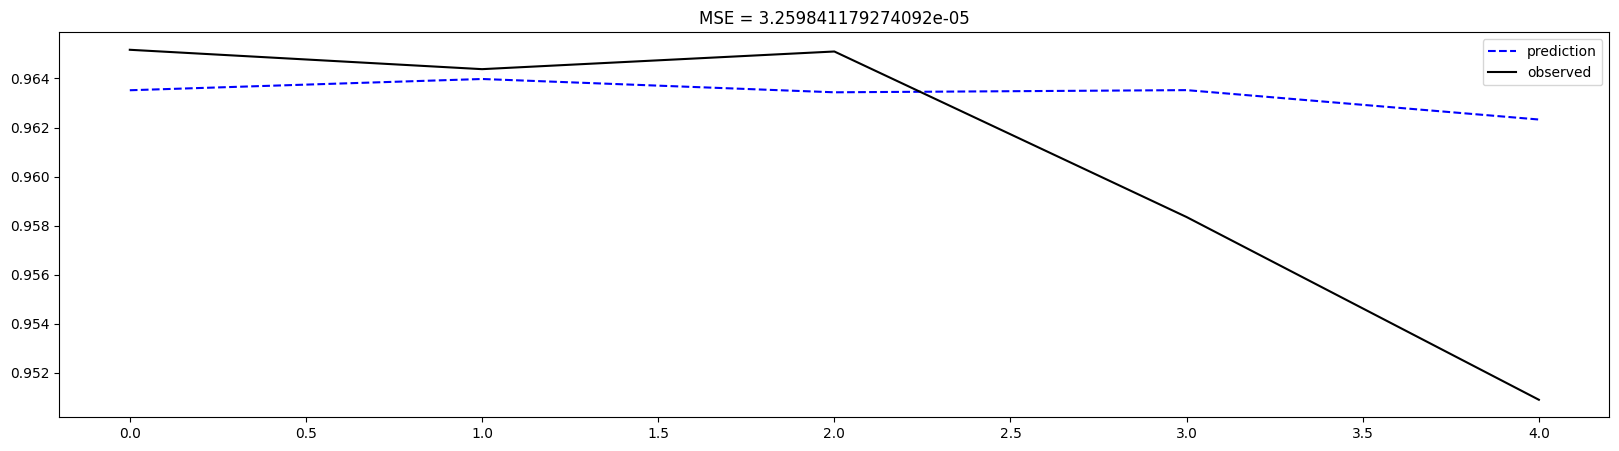

In [57]:
# plot prediction vs observed
pred = pd.DataFrame()
pred['prediction'] = data.iloc[-1]['Close'] + np.cumsum(model_fit.forecast(5, exog=diff_test[['Close', 'High', 'Open', 'Low']]).reset_index(drop=True).Close)
pred['observed'] = test.reset_index(drop=True).Close

pred.plot(figsize=(20,5),title='prediction vs observed',color=['blue','black'],style=['--','-'])
plt.title(f"MSE = {np.mean((pred['prediction'].values-pred['observed'].values)**2)}")

In [58]:
print(pred)

   prediction  observed
0    0.963520   0.96517
1    0.963979   0.96438
2    0.963436   0.96510
3    0.963525   0.95835
4    0.962326   0.95090


In [60]:
np.savetxt('predictions_eurchf.csv', pred['prediction'])

In [61]:
# Train all the data using the best p and q parameters
diff_data_all = diff(df, k_diff=1)
model = VARMAX(endog=diff_data[['Close','Gold', 'Stoxx', 'SMI']], order=(3, 10), mle_regression = True, filter_concentrated = True, initialization='approximate_diffuse')
model_fit_final = model.fit(disp=False)

In [63]:
forecast_vals = eur_chf.iloc[-1]['Close'] + np.cumsum(model_fit_final.forecast(5, exog=diff_test[['Close', 'High', 'Open', 'Low']]).reset_index(drop=True).Close)
print(forecast_vals)

0    0.949960
1    0.950419
2    0.949876
3    0.949965
4    0.948766
Name: Close, dtype: float64


In [66]:
forecast_vals.values.tofile("./predictions_eurchf.csv", sep='\n')